In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import sqlite3

# Data Preparation

In [6]:
col_names = [
    'dv', 
    'fv',
    'dv-fv'
]

In [10]:
import configparser
import warnings
from pymongo import MongoClient

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['mediacloud']

# Read from Mongo to DataFrame

In [14]:
df_data = pd.DataFrame()
for col_name in col_names:
    df_col = pd.DataFrame(list(db[col_name].find()))
    df_data = pd.concat([df_data, df_col], axis=0)
len(df_data)

12845

# Compute count for each day

## Initialize each day to 0

In [44]:
counts = {}
for year in range(2014, 2019):
    for month in range(1, 13):
        for day in range(1, compute_days_in_month(year, month)+1):
            date_str = parse_date_int_to_str(year, month, day)
            counts[date_str] = 0
            
len(counts)

1826

In [43]:
years = ['2014','2015','2016','2017','2018']
days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]


def compute_days_in_month(y, m):
    if y == 2016 and m == 2:
        return 29
    else:
        return days_in_month[m-1]
    
    
def parse_date_int_to_str(y,m,d):
    s = str(y)
    if m >= 10:
        s += str(m)
    else:
        s += '0' + str(m)
    if d >= 10:
        s += str(d)
    else:
        s += '0' + str(d)
    return s

# Actual daily and annual count


In [45]:
annual_counts = {}
for i, row in df_data.iterrows():
    date_str = row['publish_date'].split()[0]
    year = date_str.split('/')[2]
    if year in years:
        date_str = ''.join(reversed(date_str.split('/')))
        counts[date_str] = counts.get(date_str, 0) + 1
        annual_counts[year] = annual_counts.get(year, 0) + 1
        
len(counts)

1826

In [55]:
# To Data Frame (Series)
df_counts = pd.Series(counts)
df_counts.sort_index(inplace=True)
df_counts.head()

20140101    0
20140102    0
20140103    0
20140104    0
20140105    0
dtype: int64

# Draw heat map

In [2]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [3]:
def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])

    # Adjust for start and end of year
    i = list(i)
    if dates[0].month == 1:
        i = [0 if ii > 5 else ii for ii in i]
    if dates[0].month == 12:
        i = [53 if ii == 1 else ii for ii in i]

    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar
 
 
def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation='none', cmap='Reds')
    label_days(ax, dates, i, j, calendar)
    ax.set_yticklabels([])
    ax.set(yticks=[])
 
 
def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]
 
    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center', fontsize=30)
 
    ax.set(xticks=np.arange(7),
           xticklabels=['M', 'T', 'W', 'R', 'F', 'S', 'S'])
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)    
    ax.xaxis.tick_top()
    ax.set_title(month_labels[dates[0].month-1], fontsize=30)

In [4]:
def get_ax_position(month):
    x = (month - 1) // 4
    y = (month - 1) % 4
    return x, y

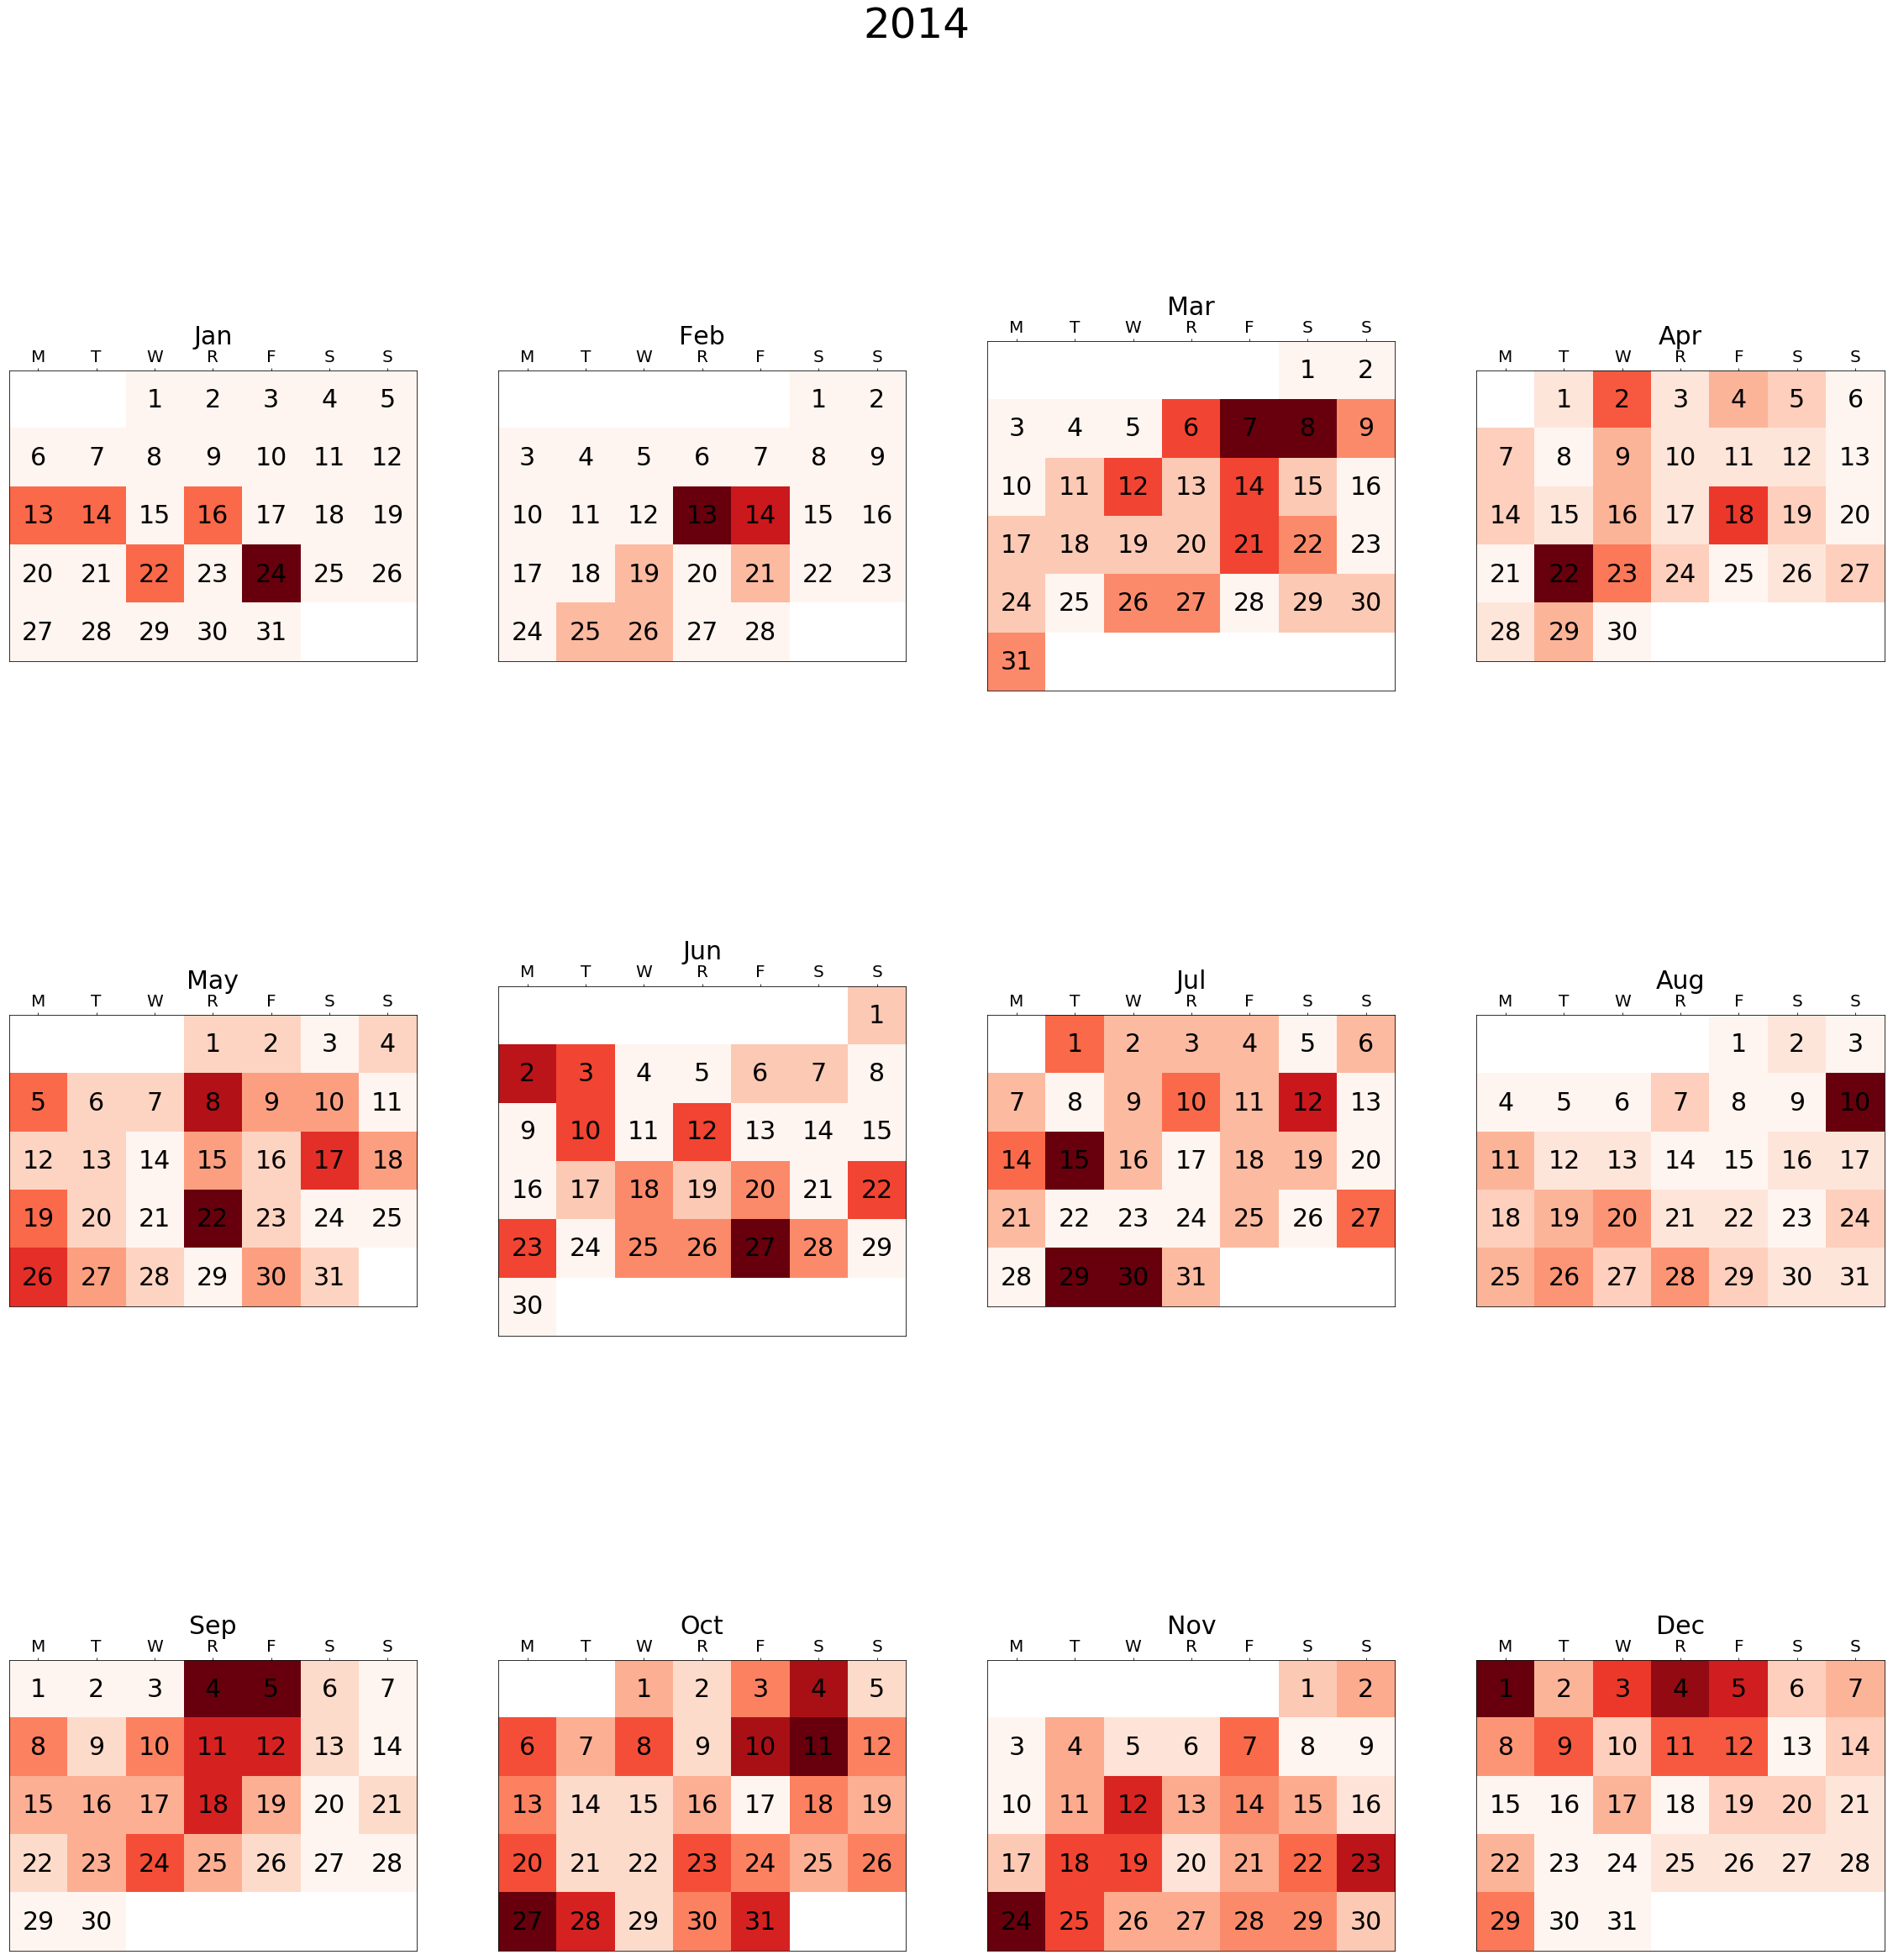

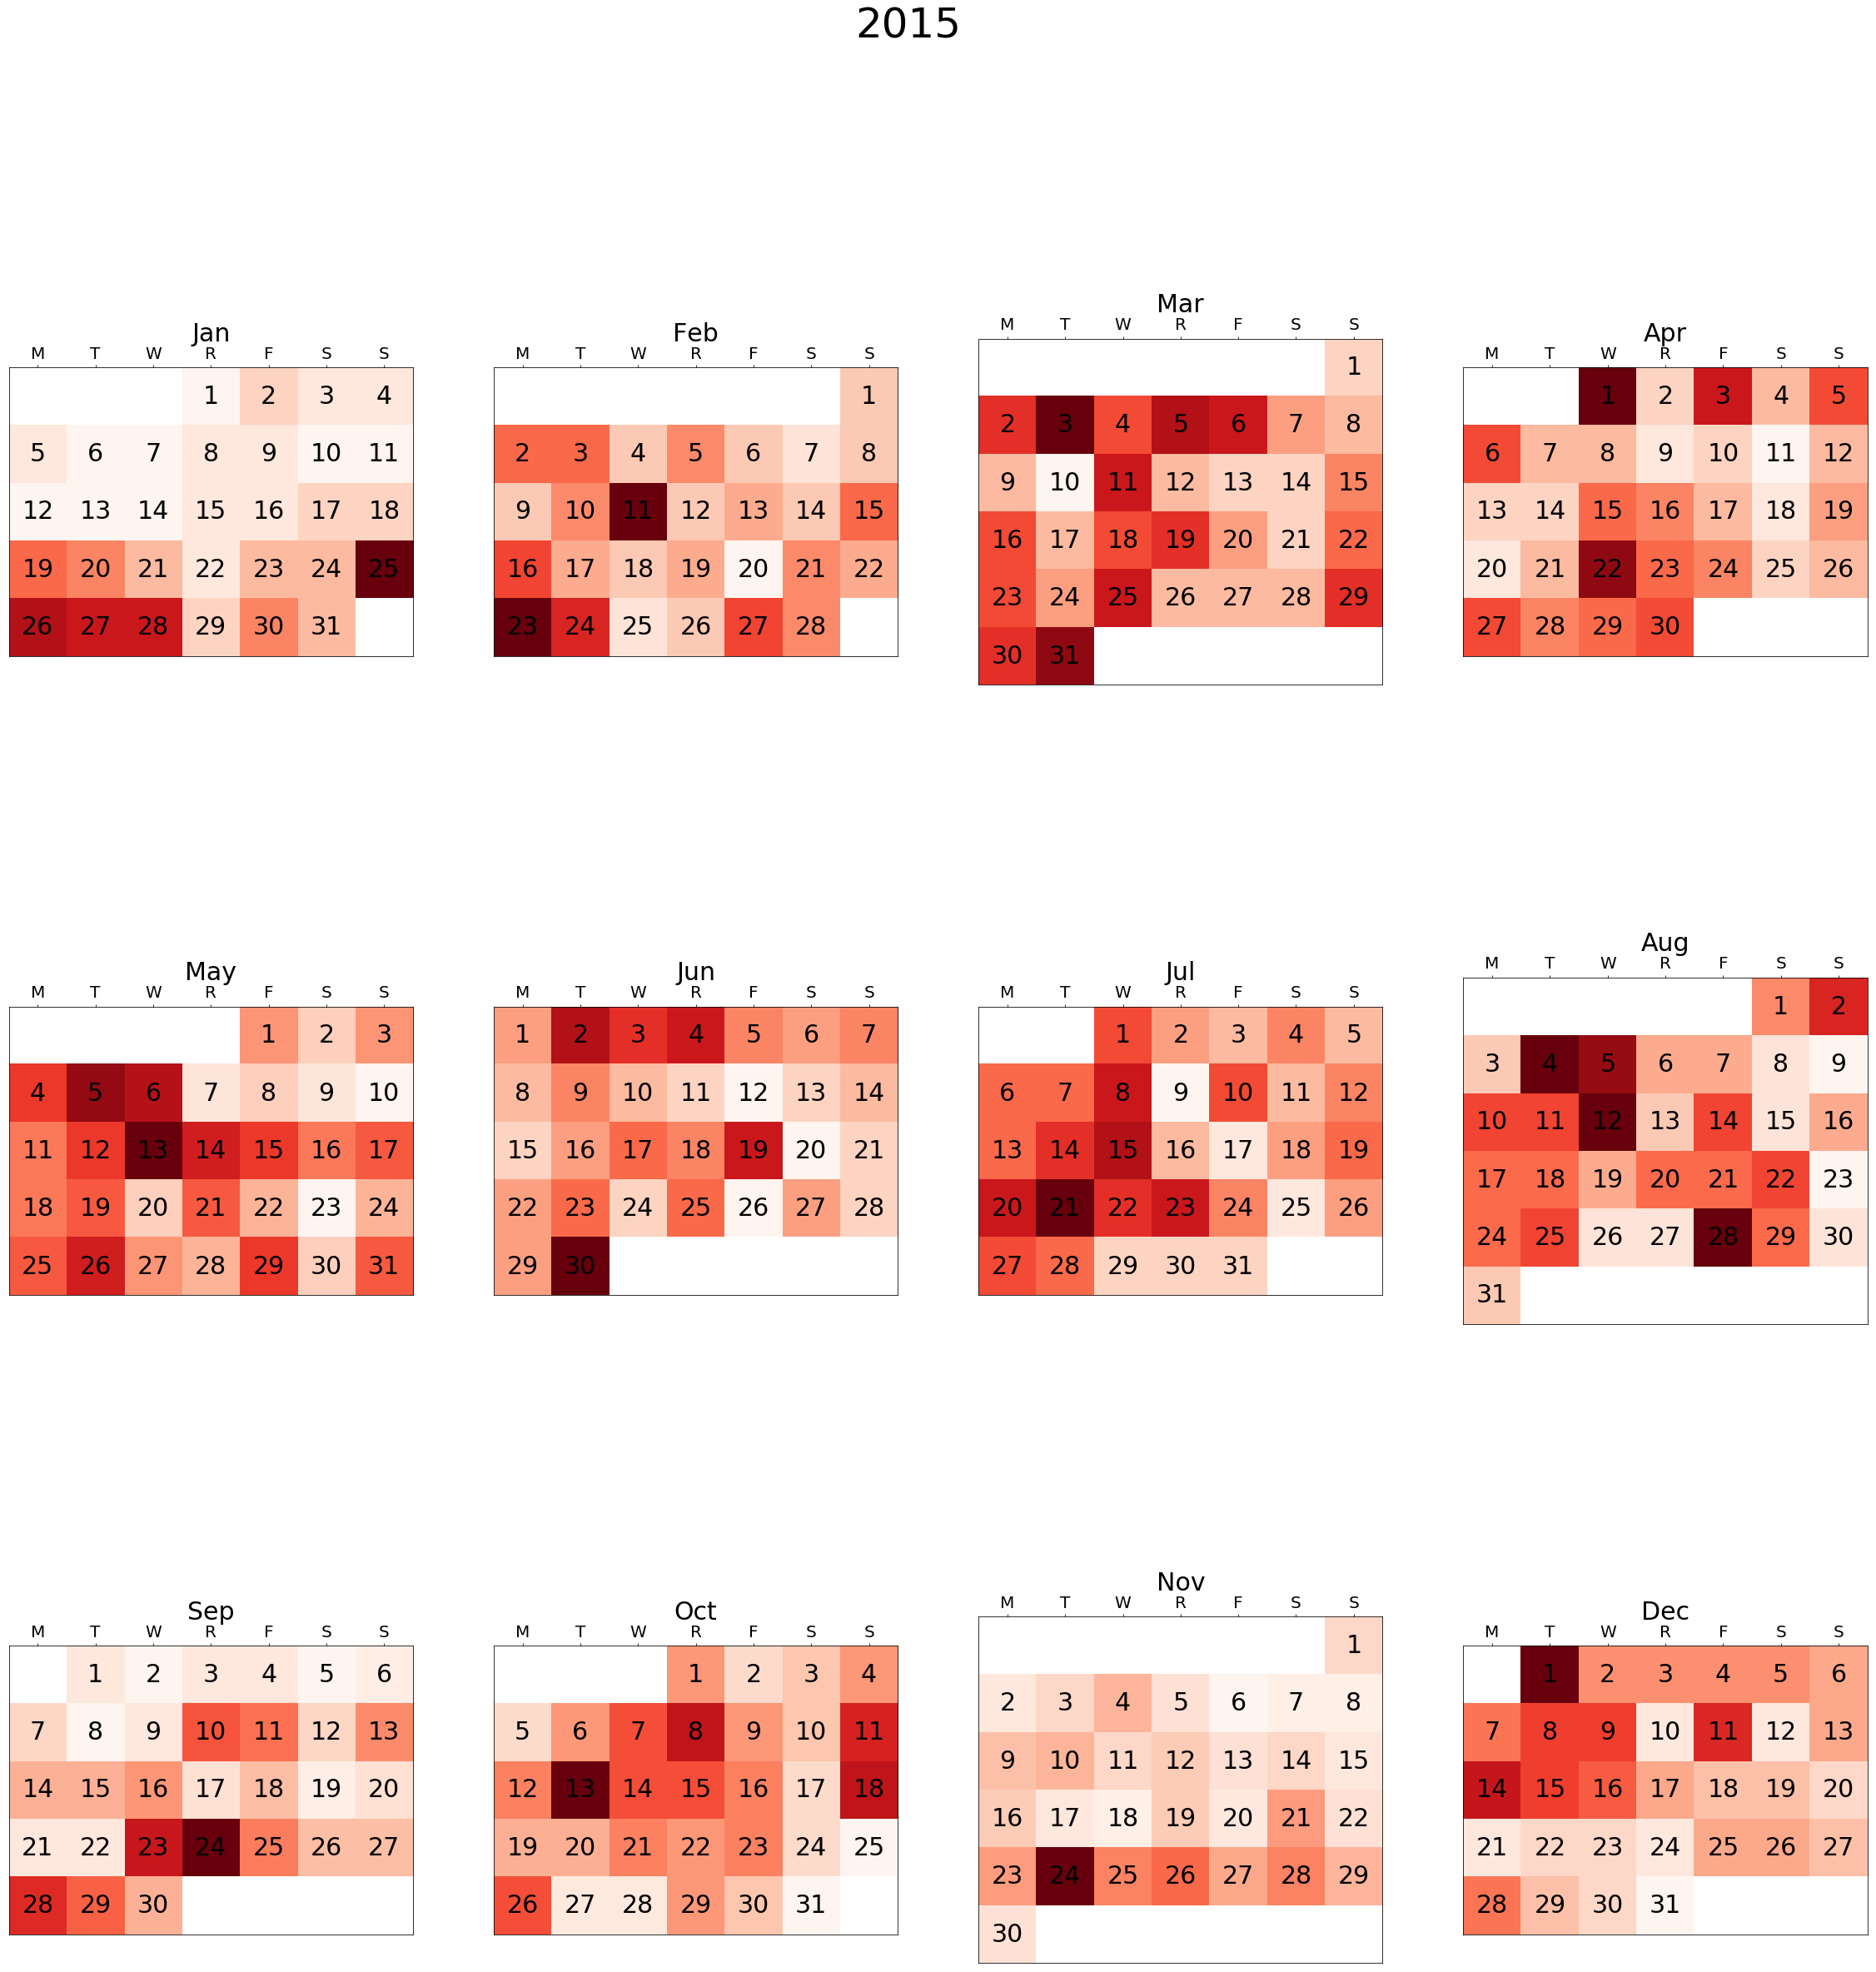

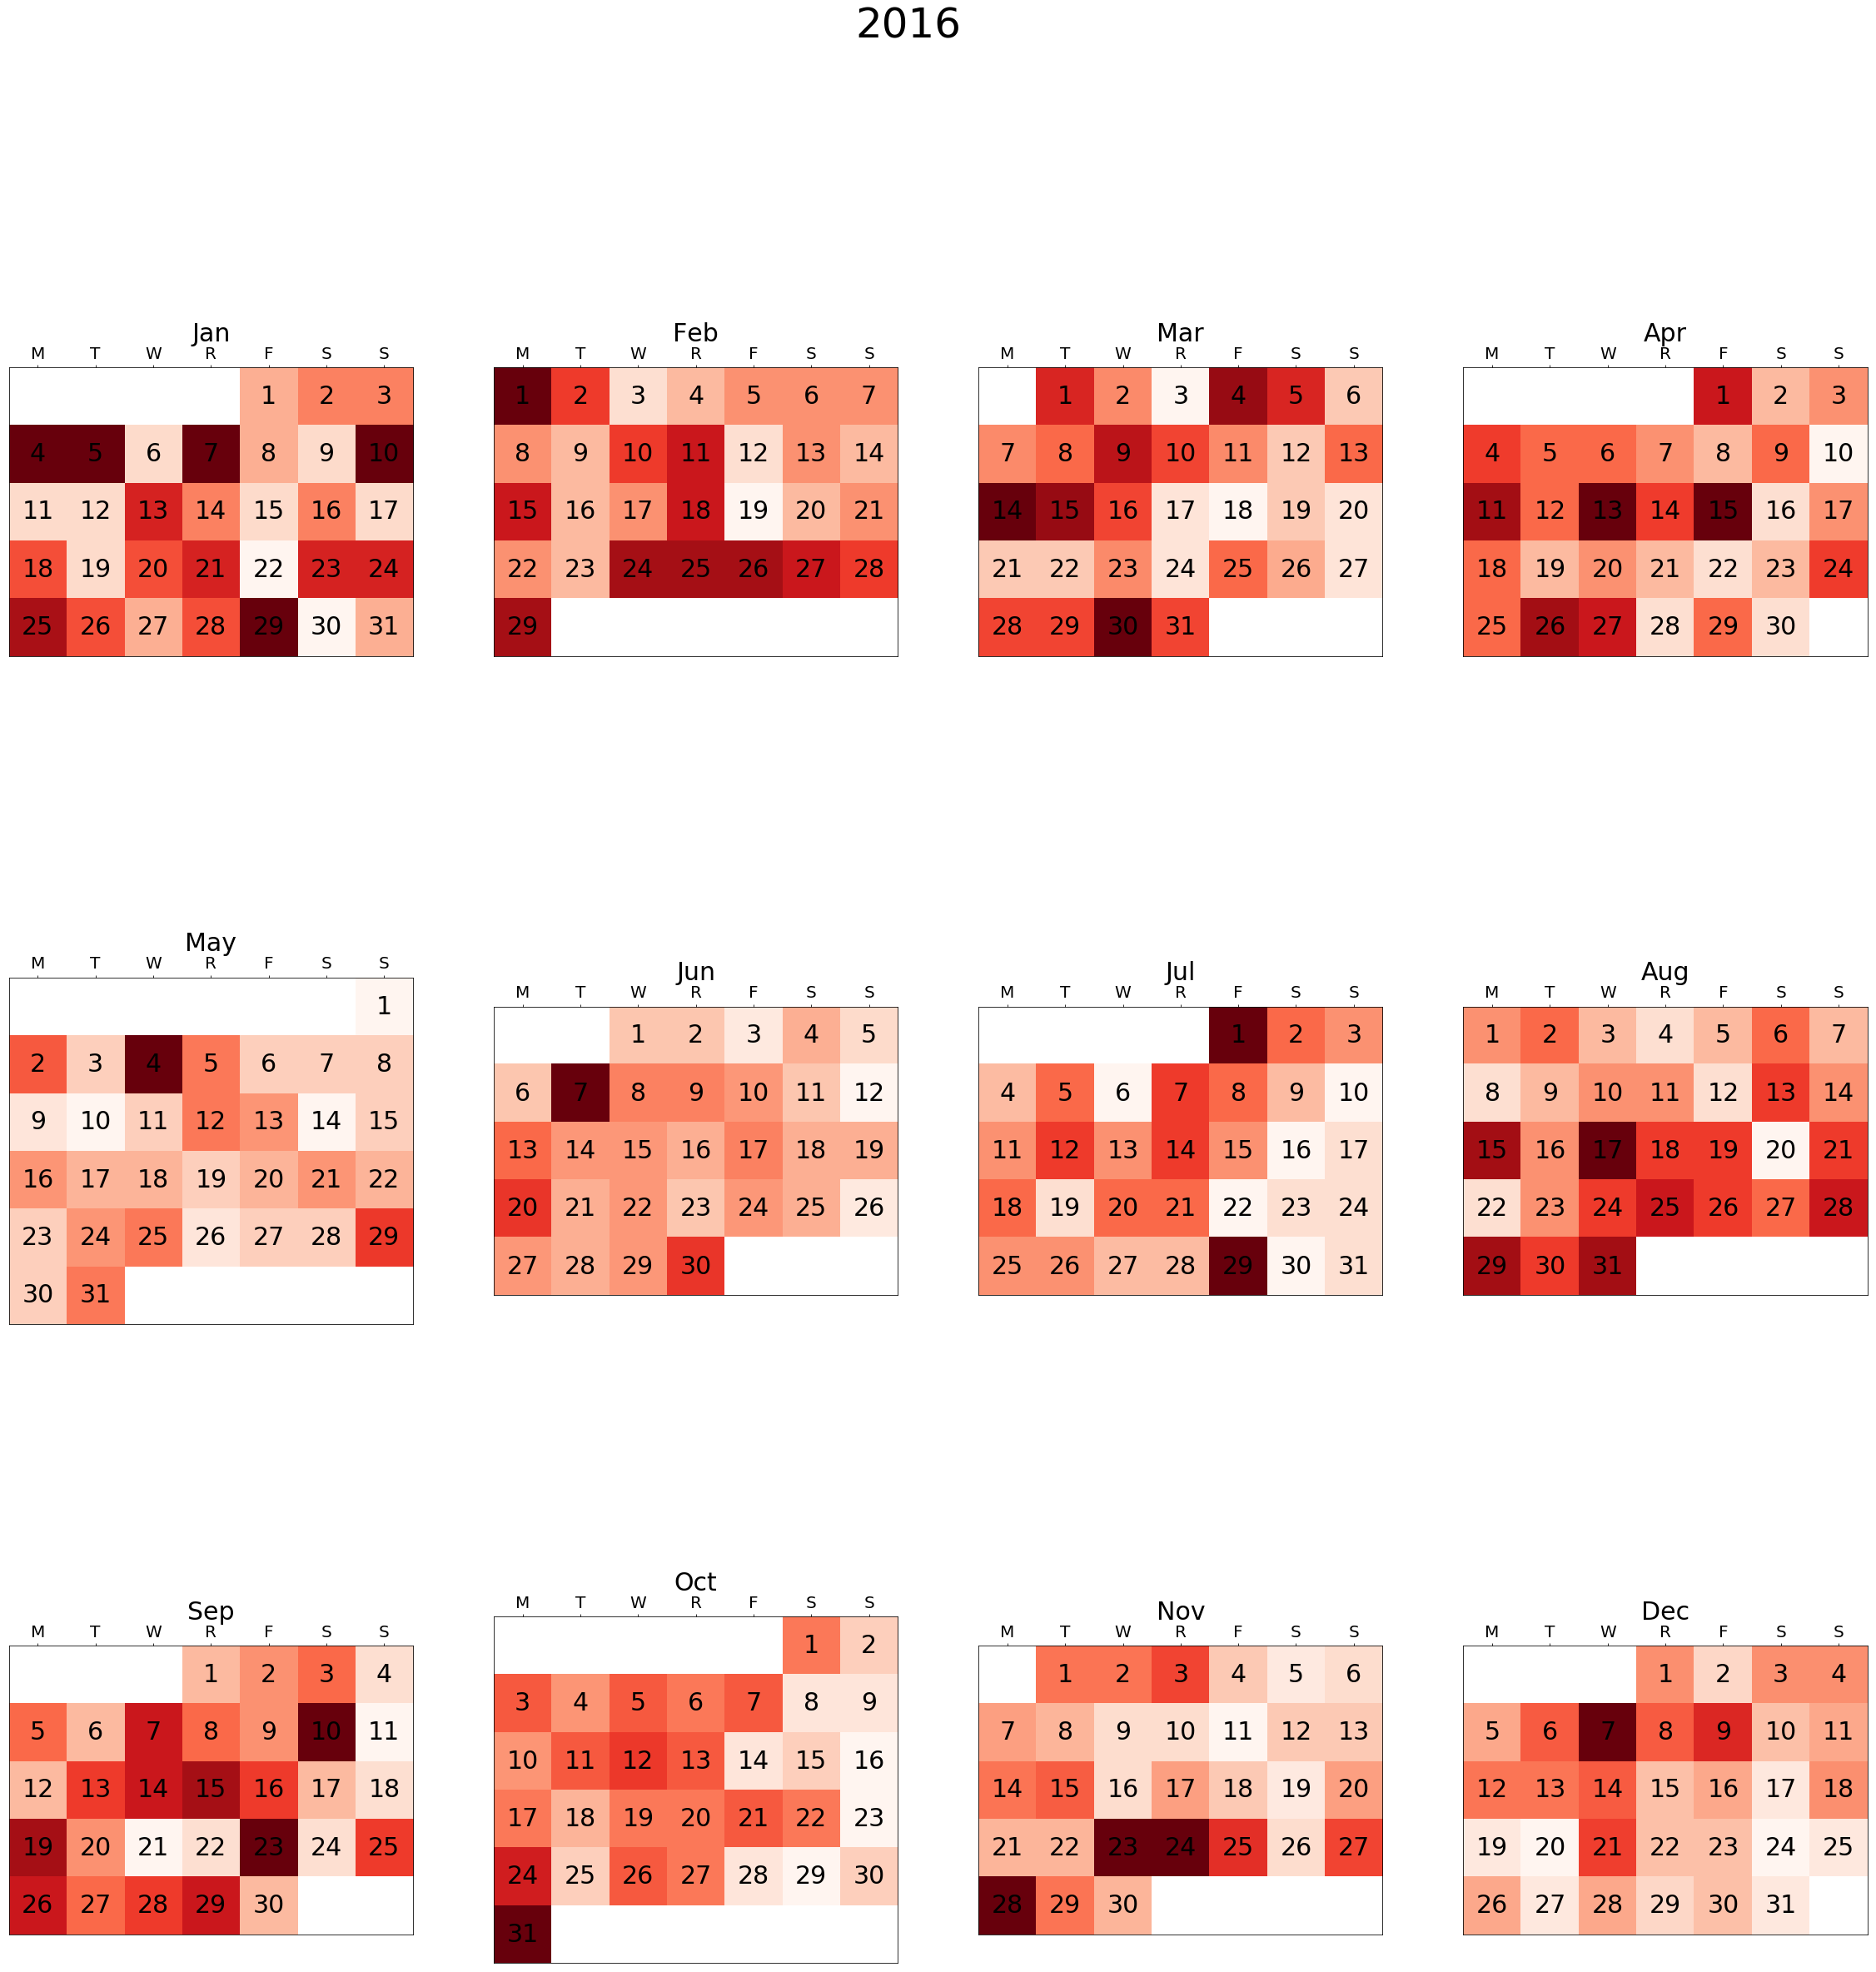

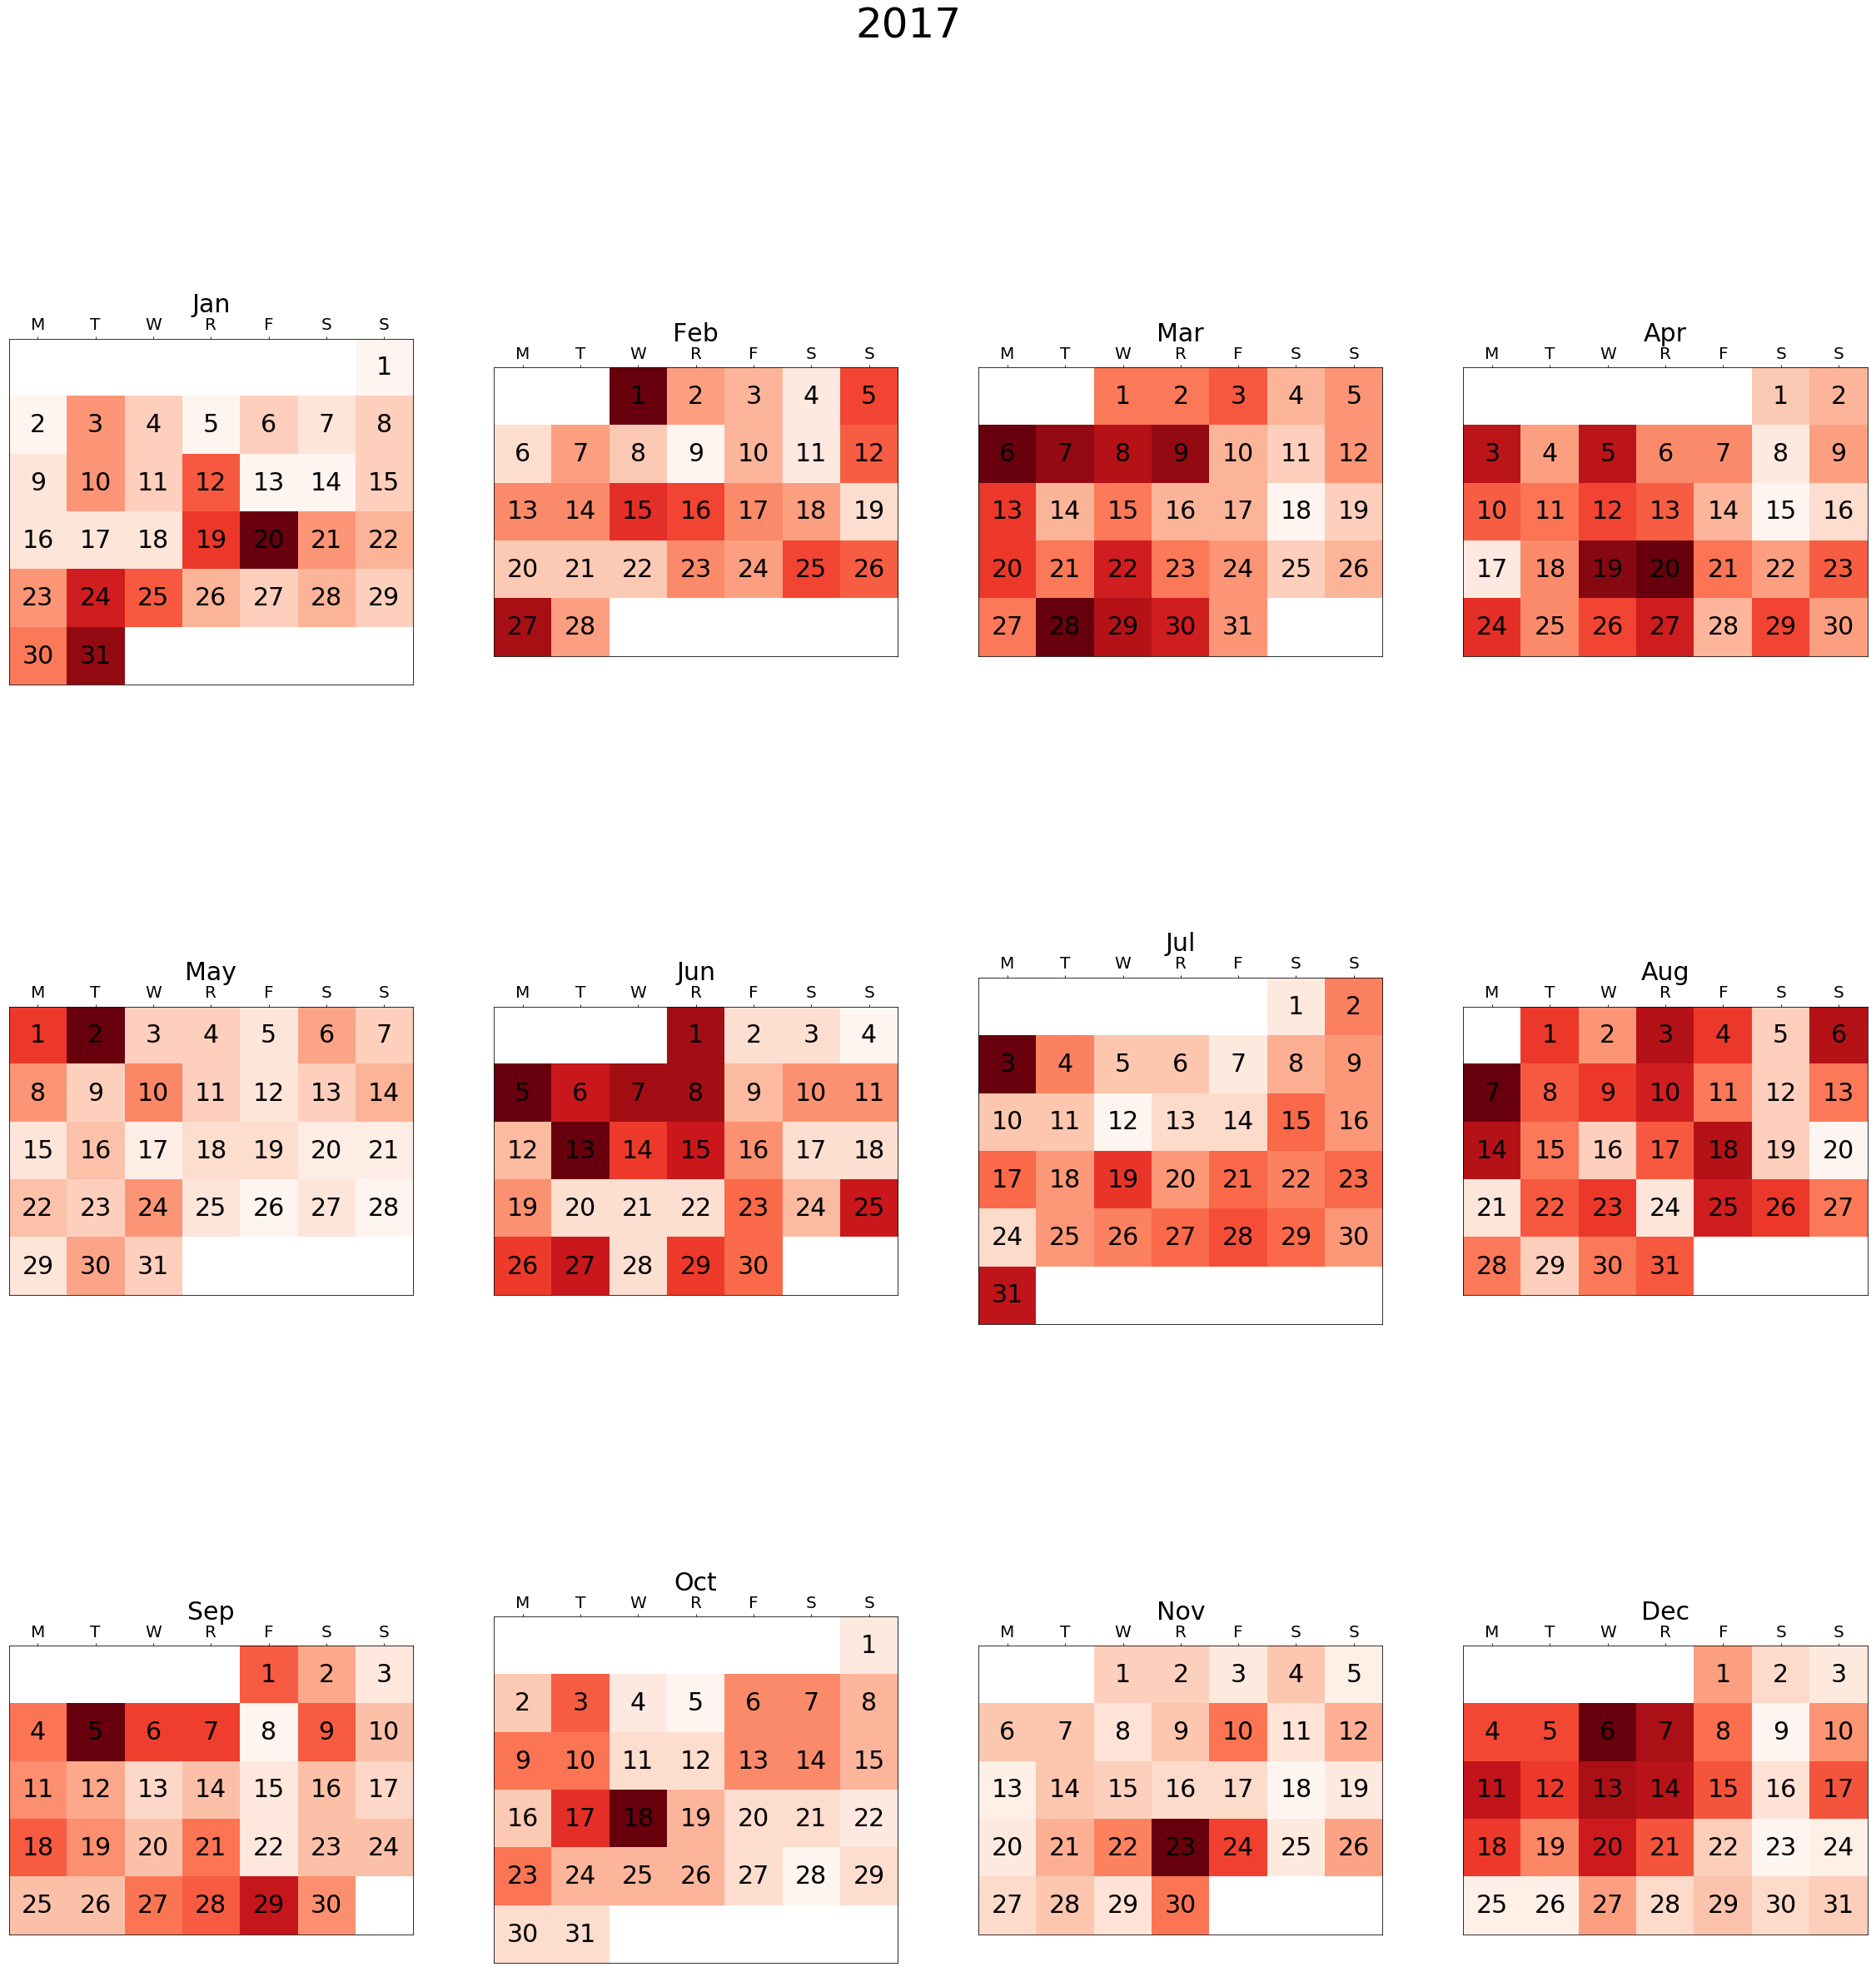

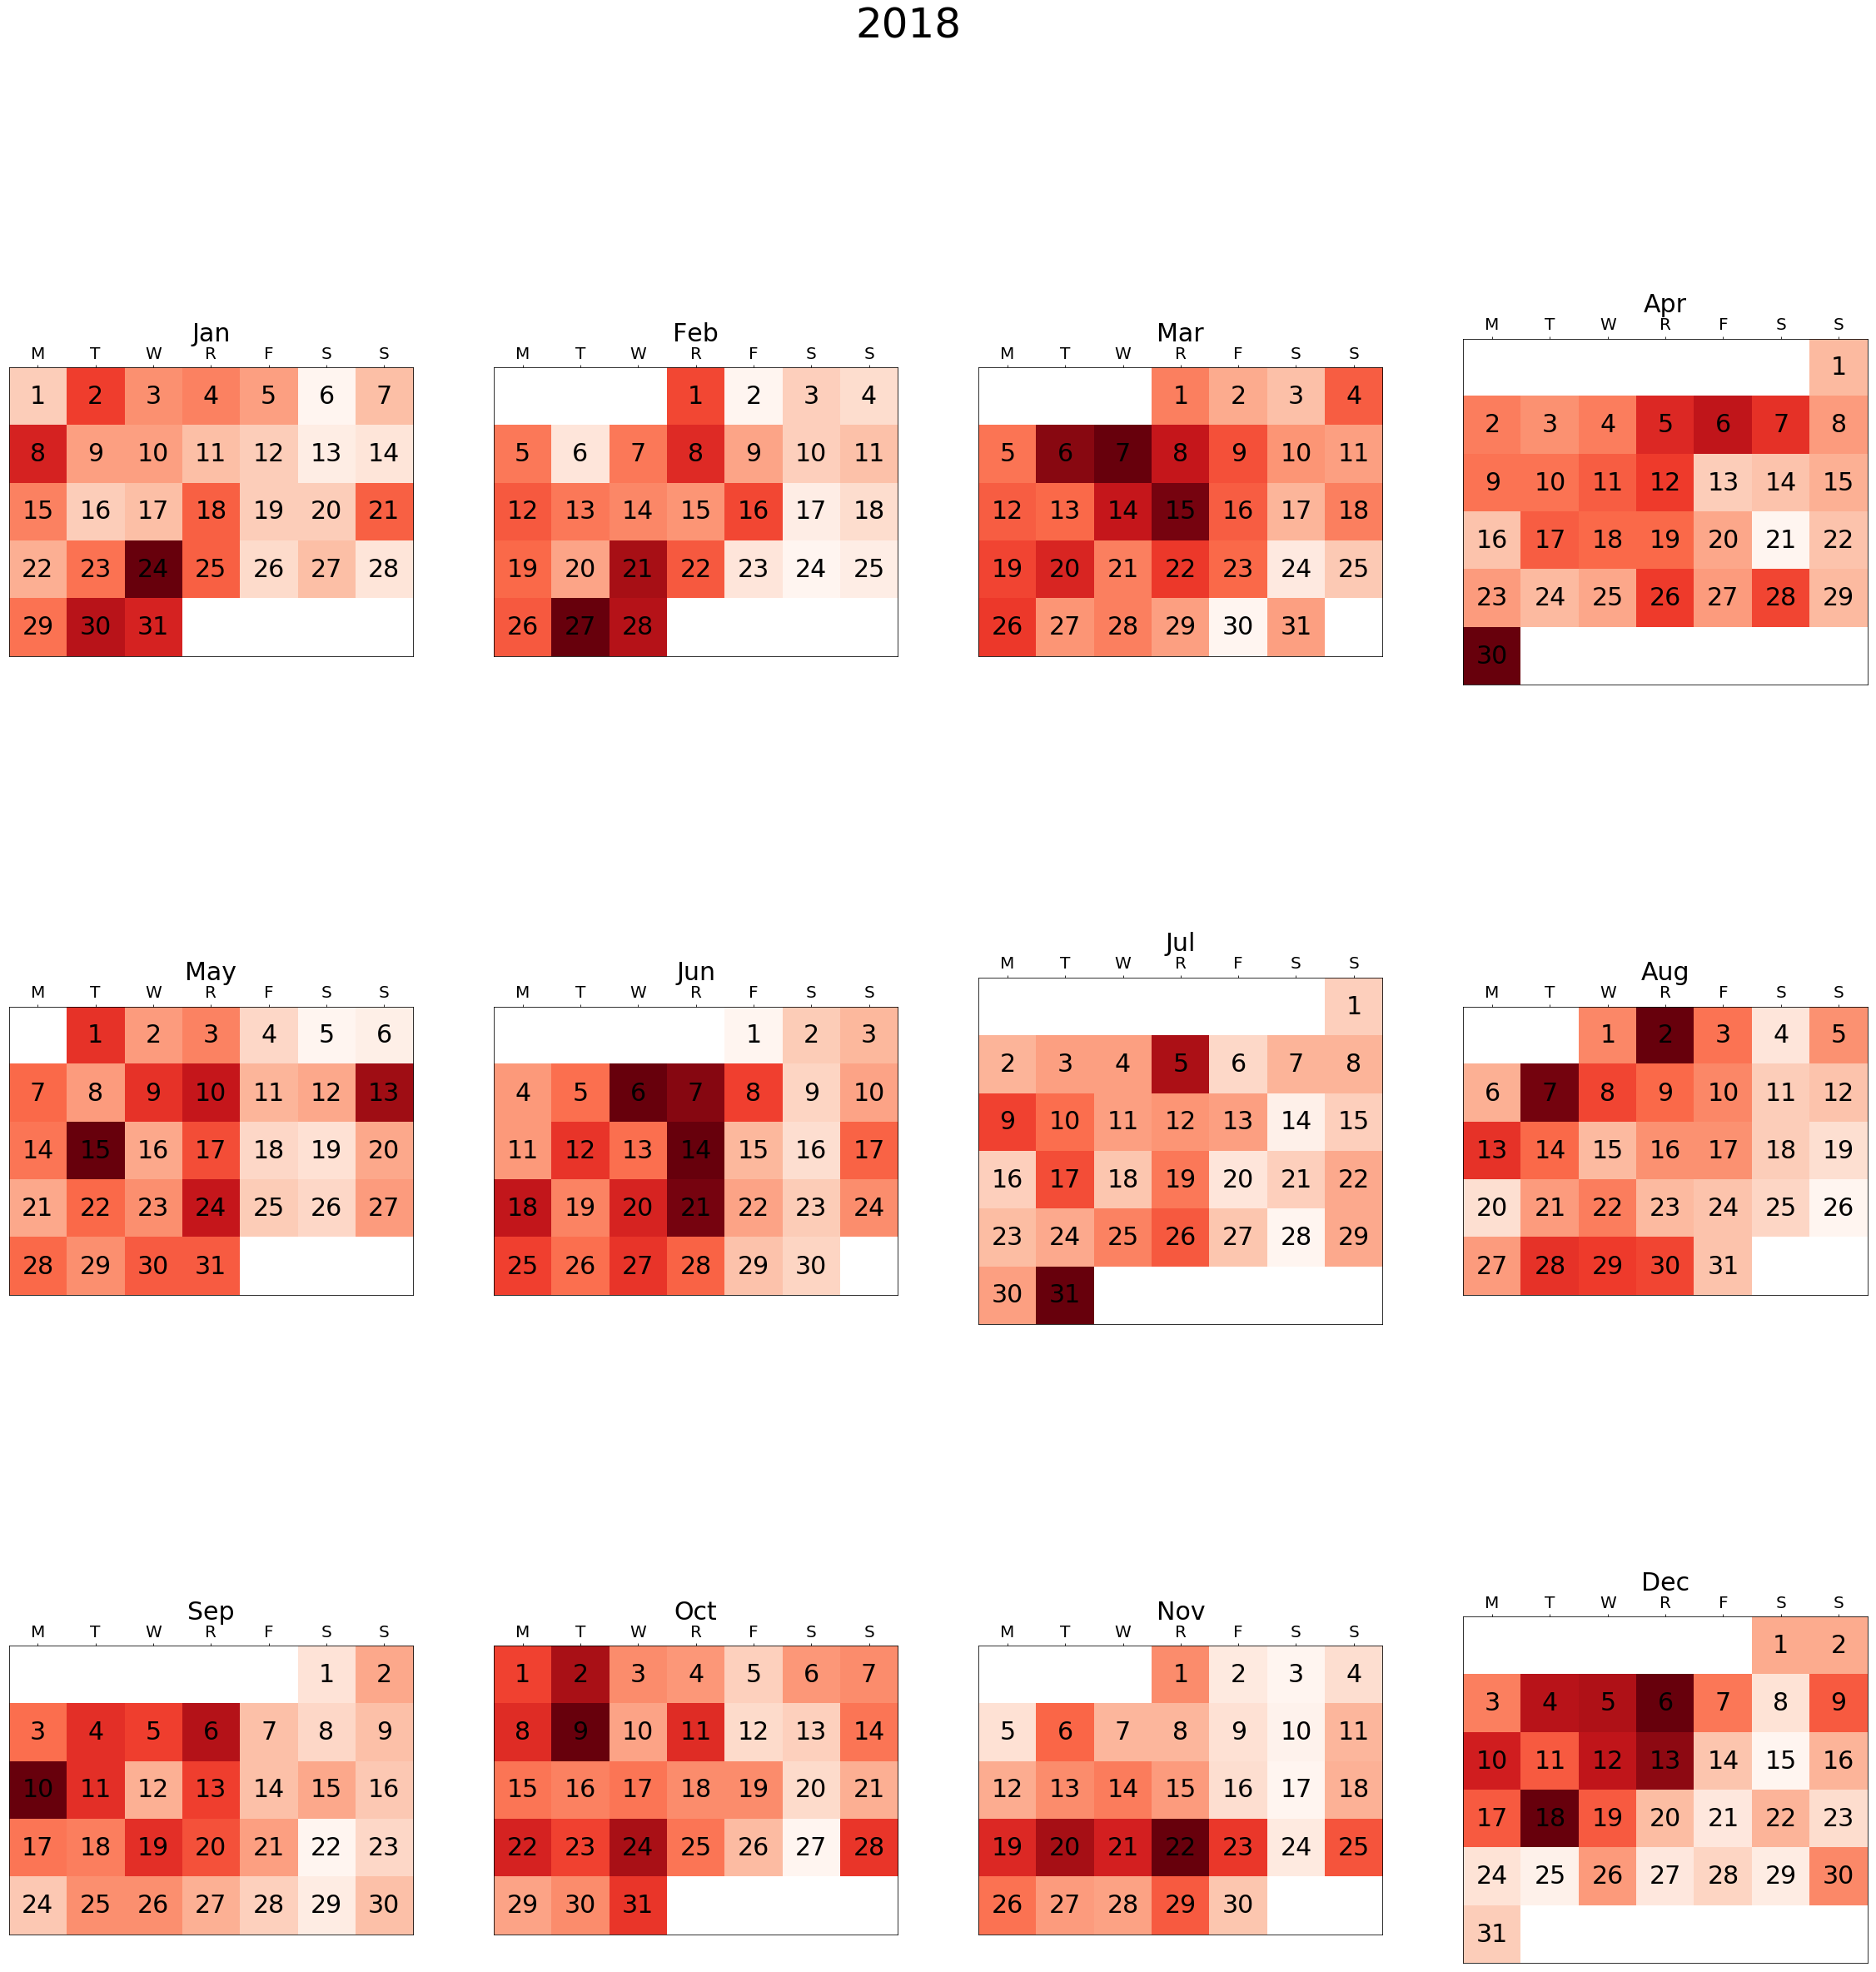

In [63]:
for year in range(2014, 2019):
    fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(40, 40))
    fig.suptitle(str(year), fontsize=50)

    for month in range(1, 13):
        df_filt = df_counts.loc[parse_date_int_to_str(year, month, 1): parse_date_int_to_str(year, month, compute_days_in_month(year, month))]

        dates = []
        for date in df_filt.index:
            dates.append(dt.datetime.strptime(date, '%Y%m%d'))

        data = df_filt
    
        x, y = get_ax_position(month)
        
        calendar_heatmap(axarr[x, y], dates, data)
        
    plt.savefig('output/heatmaps/'+str(year)+'.png')

# Retrieve news for day

In [58]:
def retrieve_news(y, m, d):
    date_str = ''
    if d < 10:
        date_str += '0'
    date_str += str(d) + '/'
    if m < 10:
        date_str += '0'
    date_str += str(m) + '/' + str(y)
    
    for i, row in df_data.iterrows():
        if date_str in row['publish_date']:
            print(row['title'])

In [62]:
# News titles
retrieve_news(2018,3,15)

Miner ‘digs deep’ for Pirie kids
Domestic violence and property damage up but most major crimes down
Murdered girl's mother tells court she played a role in torture death
Shocking CCTV footage emerges of baseballer beating up girlfriend
Early help for homeless girls and victims of domestic violence
Australia&#8217;s law reform commission to review family law relating to LGBTI people
Violence plagues police
Rihanna snaps over Chris Brown assault ‘joke’
Rihanna urges fans to delete Snapchat after ad mocking assault by Chris Brown
Rihanna urges fans to delete Snapchat
Phone jamming trial soon at Goulburn Jail
'Shame on you': Rihanna urges fans to delete Snapchat over Chris Brown ad
Coroner considers whether headlocks should be treated in same way as one-punch strikes
Craig helps kids who are being bullied
Moree ranks in top 10 hotspots for domestic violence in NSW in 2017
Motorbike rider leads police on pursuit down Old Pacific Highway
Jealous boyfriend jailed for 'disgraceful' servo atta